In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import json
import numpy as np
import seaborn as sns
import re

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', 0)

In [2]:
DOMAIN="clinical"

def replace_quotation(el):
    try:
        return json.loads(el)
    except:
        el = el.replace("\'", '"')
        
def load_csv(csv_path):
    df = pd.read_csv(csv_path).query(f"domain=='{DOMAIN}'").reset_index(drop=True)
    df.loc[:, "medical_entities"] =  df.loc[:, "detect_entities"].apply(lambda x: replace_quotation(x))
    return df

In [3]:
csv_path="../NER/entities/full_intron-train-public-58000-clean_with_entities.csv"
df_train = load_csv(csv_path)

csv_path="../NER/entities/full_intron-dev-public-3231-clean_with_entities.csv"
df_dev = load_csv(csv_path)

csv_path="../NER/entities/full_intron-test-public-6346-clean_with_entities.csv"
df_test = load_csv(csv_path)

print(len(df_train), len(df_dev), len(df_test))

36318 1824 3623


In [4]:
df_test.head(1)

,Unnamed: 0,idx,user_ids,accent,age_group,country,transcript,nchars,audio_ids,audio_paths,duration,origin,domain,split,gender,detect_entities,detect_phi,medical_entities
0,0,149716,5ab7b49ad1cab6392a764a69578dc822,twi,26-40,GH,Proteins break down to release amino acids which are used as fuel for hepatic gluconeogenesis to maintain the glucose needs of the brain.,136,3a21d00eec39a31f089b9b4f0f8afa21,/AfriSpeech-100/test/e696aff8-ce05-4c8e-a3b3-5634f3da50b9/3b55a5d83ae194039127818b59e5b78a.wav,10.776984,african,clinical,test,Female,"{\n ""Entities"": [\n {\n ""Id"": 1,\n ""BeginOffset"": 131,\n ""EndOffset"": 136,\n ""Score"": 0.9999834299087524,\n ""Text"": ""brain"",\n ""Category"": ""ANATOMY"",\n ""Type"": ""SYSTEM_ORGAN_SITE"",\n ""Traits"": []\n }\n ],\n ""UnmappedAttributes"": [],\n ""ModelVersion"": ""2.3.0""\n}\n","{\n ""Entities"": [],\n ""ModelVersion"": ""1.1.0""\n}\n","{'Entities': [{'Id': 1, 'BeginOffset': 131, 'EndOffset': 136, 'Score': 0.9999834299087524, 'Text': 'brain', 'Category': 'ANATOMY', 'Type': 'SYSTEM_ORGAN_SITE', 'Traits': []}], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}"


In [5]:
def get_entities_values(df, attribute="Score"):
    values = []
    for i in range(len(df)):
        entities = df["medical_entities"][i]
        if entities is not None:
            entities = entities["Entities"]
            for j in range(len(entities)):
                values.append(entities[j][attribute])
    return values

In [6]:
categories = list(set(get_entities_values(df_test, attribute="Category")))

# make sure the entities categories are the same for train and test
assert set(set(get_entities_values(df_train, attribute="Category"))) == set(categories)
categories

['TIME_EXPRESSION',
 'TEST_TREATMENT_PROCEDURE',
 'PROTECTED_HEALTH_INFORMATION',
 'ANATOMY',
 'BEHAVIORAL_ENVIRONMENTAL_SOCIAL',
 'MEDICATION',
 'MEDICAL_CONDITION']

We're only focusing on four categories for this project
- MEDICATION
- MEDICAL_CONDITION
- ANATOMY
- PROTECTED_HEALTH_INFORMATION

In [7]:
VALID_CATEGORIES = ["MEDICATION", "MEDICAL_CONDITION", "ANATOMY", "PROTECTED_HEALTH_INFORMATION"]

,scores_train
count,97349.000000
mean,0.851239
std,0.186356
min,0.052329
25%,0.730901
50%,0.950973
75%,0.997645
max,1.000000


,scores_test
count,9146.000000
mean,0.852707
std,0.186175
min,0.098740
25%,0.729393
50%,0.954385
75%,0.997776
max,1.000000


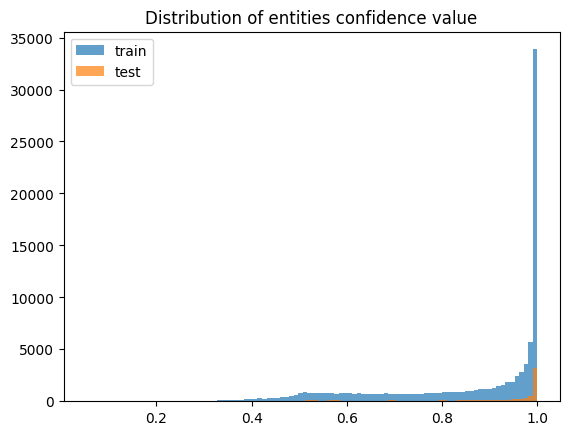

In [8]:
scores_train =  get_entities_values(df_train, attribute="Score")
display(pd.DataFrame(scores_train, columns=["scores_train"]).describe())

scores_test =  get_entities_values(df_test, attribute="Score")
display(pd.DataFrame(scores_test, columns=["scores_test"]).describe())

_ = plt.hist(scores_train, bins=100, label="train", alpha=0.7)
_ = plt.hist(scores_test, bins=100, label="test", alpha=0.7)

plt.legend()
_ = plt.title("Distribution of entities confidence value")

## Check if categories scores are calibrated to be within the same range

In [9]:
def scores_per_category(df):
    medical_entities = df.medical_entities
    scores_dict = {}
    
    for el in medical_entities:
        if el is not None:
            entities = el["Entities"]
            for entity in entities:
                text = entity["Text"]
                category = entity["Category"]
                score = entity["Score"]
                if scores_dict.get(category) is None:
                    scores_dict[category] = [score]
                else:
                    scores_dict[category].append(score)
    return scores_dict

scores_per_cat = scores_per_category(df_train)
for k in scores_per_cat.keys():
    print(f"Scores for {k}")
    print(f"Min value: {round(min(scores_per_cat[k]), 3)}", f"Max value: {round(max(scores_per_cat[k]), 3)}")
    

Scores for MEDICAL_CONDITION
Min value: 0.265 Max value: 1.0
Scores for ANATOMY
Min value: 0.25 Max value: 1.0
Scores for TIME_EXPRESSION
Min value: 0.312 Max value: 1.0
Scores for TEST_TREATMENT_PROCEDURE
Min value: 0.156 Max value: 1.0
Scores for BEHAVIORAL_ENVIRONMENTAL_SOCIAL
Min value: 0.253 Max value: 1.0
Scores for PROTECTED_HEALTH_INFORMATION
Min value: 0.052 Max value: 1.0
Scores for MEDICATION
Min value: 0.207 Max value: 1.0


### Get transcripts per category for different score ranges

In [10]:
def get_transcript_per_category(df, category, min_range, max_range):
    medical_entities = df.medical_entities
    idxs = []
    texts = []
    scores = []
    
    for idx, el in enumerate(medical_entities):
        if el is not None:
            entities = el["Entities"]
            for entity in entities:
                score = entity["Score"]
                if entity["Category"] == category and  (min_range <= score and max_range >= score):
                    idxs.append(idx)
                    texts.append(entity["Text"])
                    scores.append(score)
    df = df.iloc[idxs]
    df.loc[:, "category"] = [category]*len(df)
    df.loc[:, "text"] = texts
    df.loc[:, "score"] = scores
    return df

In [11]:
def transcript_per_category_range(df, n=1, min_range=0, max_range=1, random_state=42):
    out_df = []
    for category in VALID_CATEGORIES:
        out = get_transcript_per_category(df, category=category, min_range=min_range, max_range=max_range)
        if len(out) > n:
            out_df.append(out[["transcript", "category", "text", "score"]].sample(n, random_state=random_state))
        else:
            out_df.append(out[["transcript", "category", "text", "score"]].head(n))

    out_df = pd.concat(out_df).sort_values(["category", "score"], ascending=True)
    return out_df

In [12]:
min_range=0
max_range=0.3
random_state=42
n=1

transcript_per_category_range(df_train, n=n, min_range=min_range, max_range=max_range, random_state=random_state)

,transcript,category,text,score
25012,"Laceration of muscle, fascia and tendon of other parts of biceps, left. INJECTABLE, INJECTION BREVIBLOC, ESMOLOL HYDROCHLORIDE, 20MG/ML. Other physeal fracture of upper end of humerus, right arm, subsequent",ANATOMY,end,0.274194
5091,Cryptorchidism is unilateral in 80 cases and bilateral in the rest.,MEDICAL_CONDITION,Cryptorchidism,0.276265
602,"This cycle is interrupted by warfarin, which is structurally closely related to vitamin K, and inhibits vitamin K epoxide reductase.",MEDICATION,epoxide,0.244587
2765,They asked appropriate questions and spoke lovingly to Maigero.,PROTECTED_HEALTH_INFORMATION,Maigero,0.141019


In [13]:
min_range=0.4
max_range=0.6
random_state=42
n=1

transcript_per_category_range(df_train, n=n, min_range=min_range, max_range=max_range, random_state=random_state)

,transcript,category,text,score
26469,"Contusion of thorax, unspecified, subsequent encounter. TABLET, ORAL GLYBURIDE (MICRONIZED), GLYBURIDE, 1.5MG. Drowning and submersion after fall into bathtub, undetermined intent,",ANATOMY,thorax,0.541585
14960,"A variant of chronic pancreatitis is a non-obstructive, diffusely infiltrative disease associated with fibrosis, a mononuclear cell lymphocyte, plasma cell, or eosinophil infiltrate, and an increased titer of one or more auto-antibodies.",MEDICAL_CONDITION,chronic pancreatitis,0.506214
23941,"Type 2 diabetes mellitus with proliferative diabetic retinopathy with. INJECTABLE, INJECTION NICARDIPINE HYDROCHLORIDE, NICARDIPINE HYDROCHLORIDE, 25MG/10ML (2.5MG/ML). Unspecified subluxation of left sternoclavicular joint, subsequent enc",MEDICATION,HYDROCHLORIDE,0.519342
32662,4O/A-Mom and dad Annoh with pleasure of successful latching on.,PROTECTED_HEALTH_INFORMATION,4O,0.525669


In [14]:
min_range=0.8
max_range=1.0
random_state=42
n=1

transcript_per_category_range(df_train, n=n, min_range=min_range, max_range=max_range, random_state=random_state)

,transcript,category,text,score
12540,"The patient had a CT scan, which revealed a mass in the gallbladder neck, but no biliary dilatation .",ANATOMY,gallbladder neck,0.997106
20150,No systemic adverse effects of ribavirin have been reported following administration by aerosol or nebulizer.,MEDICAL_CONDITION,systemic adverse effects of ribavirin,0.847955
36247,"Nondisplaced avulsion fracture (chip fracture) of right talus, sequela. FOR SUSPENSION, ORAL E-Z-EM PREP LYTE, POLYETHYLENE GLYCOL 3350; POTASSIUM CHLORIDE; SODIUM BICARBONATE; SODIUM CHLORIDE; SODIUM SULFATE ANHYDROUS, 236GM/BOT;2.97GM/BOT;6.74GM/BOT;5.86GM/BOT;22.74GM/BOT. Lead-induced chronic gout, left knee, with tophus (tophi)",MEDICATION,POTASSIUM CHLORIDE,0.802842
7642,Lippincott Company 6th edition 1994 4.,PROTECTED_HEALTH_INFORMATION,1994,0.929802


### Set Score threshold

In [15]:
SCORE_THRESHOLD=0.0

### Remove NaN entities

In [16]:
# remove nan instances
df_test = df_test[~df_test["medical_entities"].isna()]
df_train = df_train[~df_train["medical_entities"].isna()]
df_dev = df_dev[~df_dev["medical_entities"].isna()]

### Plot distributions of entities

In [17]:
def count_entities(row, category=None):
    el = row["medical_entities"]
    entities = el["Entities"]
    count = 0
    for entity in entities:
        text = entity["Text"]
        text = text.rstrip("")
        score = entity["Score"]
        entity_category = entity["Category"]

        if category == entity_category and category in VALID_CATEGORIES and score >= SCORE_THRESHOLD:
            if len(text) > 1:
                count += 1
    return count

for category in VALID_CATEGORIES:
    df_test[f"{category}_count"] = df_test.apply(lambda x: count_entities(x, category), axis=1)
    df_train[f"{category}_count"] = df_train.apply(lambda x: count_entities(x, category), axis=1)
    df_dev[f"{category}_count"] = df_dev.apply(lambda x: count_entities(x, category), axis=1)

In [18]:
VALID_CATEGORIES_COUNT = [f"{category}_count" for category in VALID_CATEGORIES]
def plot_entities_distribution(df, subset):
    df_categories = df[VALID_CATEGORIES_COUNT]
    g = sns.barplot(df_categories)
    _ = plt.xticks(rotation=30) 
    plt.title(f"Distribution of Entities [{subset}]")

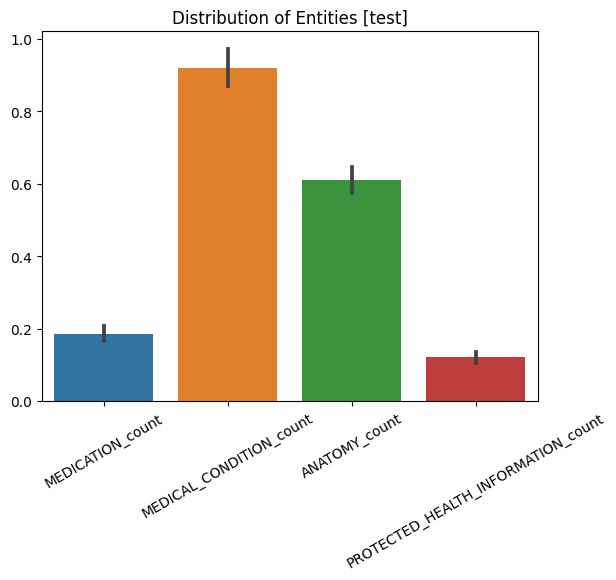

In [19]:
plot_entities_distribution(df_test, subset="test")

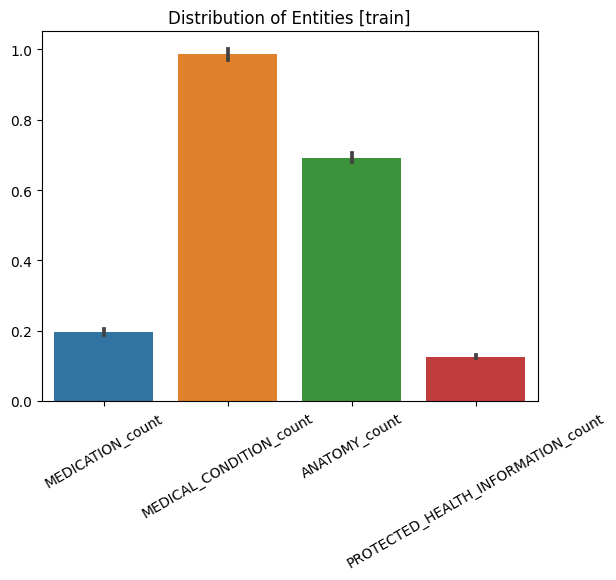

In [20]:
plot_entities_distribution(df_train, subset="train")

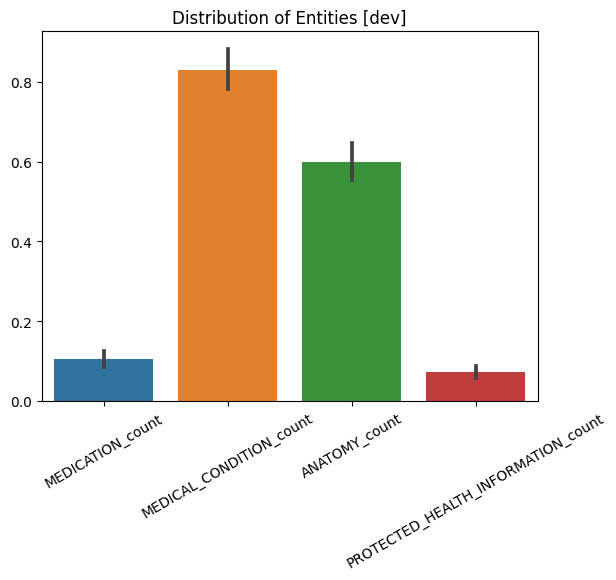

In [21]:
plot_entities_distribution(df_dev, subset="dev")

### Extract Entities
We will only focus on the test set

In [22]:
# find character that can be used to join the texts
candidate_char = ["_", " ", "-", ";"]
all_chars_in_transcript = set("".join(list(df_test["transcript"].values)))

JOIN_CHAR = None

for char in candidate_char:
    
    if char in all_chars_in_transcript:
        continue
    else:
        JOIN_CHAR = char

if JOIN_CHAR is None:
    JOIN_CHAR = ""
    
print(JOIN_CHAR)

_


In [23]:
def concat_all_entities(row):
    transcript = row['transcript'].lower()
    el = row["medical_entities"]
    entities = el["Entities"]
    texts = []
    
    for entity in entities:
        text = entity["Text"].lower().rstrip("")
        score = entity["Score"]
        entity_category = entity["Category"]

        if entity_category in VALID_CATEGORIES and score >= SCORE_THRESHOLD:
            # we want to avoid single character matches
            if len(text) > 1:
#                 text_index = transcript.index(text)
                try:
                    text_index = transcript.index(text)
                    texts.append(text.lower())
                
                except Exception as e:
                    print(f"---Exception: {e}")
                    print(f"Entity: {text}")
                    print(f"Transcript: {transcript}")
                    print(f"Index: {row['idx']}")
                    # manually found exceptions
                    if text == "paino":
                        text = text.replace('paino', 'pain')
                        texts.append(text.lower())
                    else:
                        raise e
                    
    return f"{JOIN_CHAR}".join(texts)

# These two functions could be merged. 
# They were separated for ease of readability and debugging purposes
def concat_entities(row, category):
    el = row["medical_entities"]
    entities = el["Entities"]
    texts = []
    for entity in entities:
        text = entity["Text"].lower().rstrip("")
        score = entity["Score"]
        entity_category = entity["Category"]

        if category == entity_category and category in VALID_CATEGORIES and score >= SCORE_THRESHOLD:
            if len(text) > 1:
                
                # apply entities corrected in previous step
                if text == "paino":
                    text = text.replace('paino', 'pain')
                
                texts.append(text)

    return f"{JOIN_CHAR}".join(texts)

In [24]:
df_test["cat_entities"] = df_test.apply(lambda x: concat_all_entities(x), axis=1)

---Exception: substring not found
Entity: paino
Transcript: sepsiss: ""i have to go to the bathroom"" ""no i'm not having any pain""o: cardiac: sr 70's-90's without atrial or ventricular arrythymias.
Index: 481459


In [25]:
df_test[df_test.idx==481459]["cat_entities"]

2049    sepsiss_pain_cardiac_sr_atrial_ventricular_arrythymias
Name: cat_entities, dtype: object

In [26]:
df_test[["domain", "transcript", "medical_entities", "cat_entities"]].sample(1)

,domain,transcript,medical_entities,cat_entities
260,clinical,Copper is transported in the blood by an alpha globulin called ceruloplasmin.,"{'Entities': [], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}",


In [27]:
for category in VALID_CATEGORIES:
    df_test[category] = df_test.apply(lambda x: concat_entities(x, category), axis=1)

In [28]:
df_test[["domain", "transcript", "medical_entities", "cat_entities", *VALID_CATEGORIES]].sample(1)

,domain,transcript,medical_entities,cat_entities,MEDICATION,MEDICAL_CONDITION,ANATOMY,PROTECTED_HEALTH_INFORMATION
1786,clinical,"Fracture of condylar process of right mandible, subsequent encounter f. TABLET, ORAL LAMIVUDINE; TENOFOVIR DISOPROXIL FUMARATE; NEVIRAPINE, LAMIVUDINE; TENOFOVIR DISOPROXIL FUMARATE; NEVIRAPINE, 300MG; 300MG; 200MG. Displaced fracture of lateral condyle of right femur, subsequent encou","{'Entities': [{'Id': 1, 'BeginOffset': 0, 'EndOffset': 8, 'Score': 0.8471072316169739, 'Text': 'Fracture', 'Category': 'MEDICAL_CONDITION', 'Type': 'DX_NAME', 'Traits': [{'Name': 'DIAGNOSIS', 'Score': 0.6810311675071716}], 'Attributes': [{'Type': 'DIRECTION', 'Score': 0.9999951124191284, 'RelationshipScore': 0.9997143149375916, 'RelationshipType': 'DIRECTION', 'Id': 3, 'BeginOffset': 32, 'EndOffset': 37, 'Text': 'right', 'Category': 'ANATOMY', 'Traits': []}, {'Type': 'SYSTEM_ORGAN_SITE', 'Score': 0.9999864101409912, 'RelationshipScore': 0.9992967844009399, 'RelationshipType': 'SYSTEM_ORGAN_SITE', 'Id': 4, 'BeginOffset': 38, 'EndOffset': 46, 'Text': 'mandible', 'Category': 'ANATOMY', 'Traits': []}]}, {'Id': 4, 'BeginOffset': 38, 'EndOffset': 46, 'Score': 0.9999864101409912, 'Text': 'mandible', 'Category': 'ANATOMY', 'Type': 'SYSTEM_ORGAN_SITE', 'Traits': []}, {'Id': 9, 'BeginOffset': 129, 'EndOffset': 139, 'Score': 0.8705745339393616, 'Text': 'NEVIRAPINE', 'Category': 'MEDICATION', 'Type': 'GENERIC_NAME', 'Traits': []}, {'Id': 10, 'BeginOffset': 141, 'EndOffset': 151, 'Score': 0.9344121813774109, 'Text': 'LAMIVUDINE', 'Category': 'MEDICATION', 'Type': 'GENERIC_NAME', 'Traits': []}, {'Id': 11, 'BeginOffset': 184, 'EndOffset': 194, 'Score': 0.9872679114341736, 'Text': 'NEVIRAPINE', 'Category': 'MEDICATION', 'Type': 'GENERIC_NAME', 'Traits': []}, {'Id': 2, 'BeginOffset': 227, 'EndOffset': 235, 'Score': 0.9493807554244995, 'Text': 'fracture', 'Category': 'MEDICAL_CONDITION', 'Type': 'DX_NAME', 'Traits': [{'Name': 'DIAGNOSIS', 'Score': 0.9172526001930237}], 'Attributes': [{'Type': 'DIRECTION', 'Score': 0.9944443106651306, 'RelationshipScore': 0.9992853999137878, 'RelationshipType': 'DIRECTION', 'Id': 5, 'BeginOffset': 239, 'EndOffset': 246, 'Text': 'lateral', 'Category': 'ANATOMY', 'Traits': []}, {'Type': 'SYSTEM_ORGAN_SITE', 'Score': 0.8156974911689758, 'RelationshipScore': 0.9985207915306091, 'RelationshipType': 'SYSTEM_ORGAN_SITE', 'Id': 6, 'BeginOffset': 247, 'EndOffset': 254, 'Text': 'condyle', 'Category': 'ANATOMY', 'Traits': []}, {'Type': 'DIRECTION', 'Score': 0.9999752044677734, 'RelationshipScore': 0.9980455636978149, 'RelationshipType': 'DIRECTION', 'Id': 7, 'BeginOffset': 258, 'EndOffset': 263, 'Text': 'right', 'Category': 'ANATOMY', 'Traits': []}, {'Type': 'SYSTEM_ORGAN_SITE', 'Score': 0.9999752044677734, 'RelationshipScore': 0.9997329115867615, 'RelationshipType': 'SYSTEM_ORGAN_SITE', 'Id': 8, 'BeginOffset': 264, 'EndOffset': 269, 'Text': 'femur', 'Category': 'ANATOMY', 'Traits': []}]}, {'Id': 6, 'BeginOffset': 247, 'EndOffset': 254, 'Score': 0.8156974911689758, 'Text': 'condyle', 'Category': 'ANATOMY', 'Type': 'SYSTEM_ORGAN_SITE', 'Traits': []}, {'Id': 8, 'BeginOffset': 264, 'EndOffset': 269, 'Score': 0.9999752044677734, 'Text': 'femur', 'Category': 'ANATOMY', 'Type': 'SYSTEM_ORGAN_SITE', 'Traits': []}], 'UnmappedAttributes': [{'Type': 'ANATOMY', 'Attribute': {'Type': 'DIRECTION', 'Score': 0.9999951124191284, 'Id': 3, 'BeginOffset': 32, 'EndOffset': 37, 'Text': 'right', 'Category': 'ANATOMY', 'Traits': []}}, {'Type': 'ANATOMY', 'Attribute': {'Type': 'DIRECTION', 'Score': 0.9944443106651306, 'Id': 5, 'BeginOffset': 239, 'EndOffset': 246, 'Text': 'lateral', 'Category': 'ANATOMY', 'Traits': []}}, {'Type': 'ANATOMY', 'Attribute': {'Type': 'DIRECTION', 'Score': 0.9999752044677734, 'Id': 7, 'BeginOffset': 258, 'EndOffset': 263, 'Text': 'right', 'Category': 'ANATOMY', 'Traits': []}}], 'ModelVersion': '2.3.0'}",fracture_mandible_nevirapine_lamivudine_nevirapine_fracture_condyle_femur,nevirapine_lamivudine_nevirapine

In [29]:
df_test[df_test.idx==481459][["MEDICAL_CONDITION"]]

,MEDICAL_CONDITION
2049,sepsiss_pain_sr_arrythymias


In [30]:
df_test[[*VALID_CATEGORIES, *VALID_CATEGORIES_COUNT]]

,MEDICATION,MEDICAL_CONDITION,ANATOMY,PROTECTED_HEALTH_INFORMATION,MEDICATION_count,MEDICAL_CONDITION_count,ANATOMY_count,PROTECTED_HEALTH_INFORMATION_count
0,,,brain,,0,0,1,0
1,,patent against the party,,grant,0,1,0,1
2,,peristalsis,,,0,1,0,0
3,,,,,0,0,0,0
4,,,,,0,0,0,0
...,...,...,...,...,...,...,...,...
3618,,fracture,proximal phalanx_finger_muscle_tendon_long extensor muscle_toe,,0,1,6,0
3619,,myocardial infarction,,,0,1,0,0
3620,bacitracin zinc,,,,1,0,0,0
3621,,,,,0,0,0,0


### Filter out empty concatenated entities

In [31]:
df_test = df_test[df_test["cat_entities"] != ""].reset_index(drop=False)

In [32]:
len(df_test)

2454

### Load the pretrained and finetuned model result csv files

In [33]:
# All the pretrained model results are stored here
pretrained_df = pd.read_csv("../results/normalized/intron-open-test-all_models.csv")
print(pretrained_df.shape)

# This is finetuned model result
finetuned_df = pd.read_csv("../results/normalized/intron-open-test-all_models_finetuned.csv")
print(finetuned_df.shape)

# Only consider general domain samples
pretrained_df = pretrained_df[pretrained_df.domain == DOMAIN]

finetuned_df = finetuned_df[finetuned_df.domain == DOMAIN]

pretrained_df["model_tag"] = "pretrained"
finetuned_df["model_tag"] = "finetuned"


print(len(pretrained_df), len(finetuned_df))

(103949, 15)
(32826, 15)
59033 18642


In [34]:
df_combined = pd.concat([pretrained_df, finetuned_df])
print(len(df_combined))

# Conduct analysis on Test set 
columns=["idx", "transcript", "medical_entities", "cat_entities", *VALID_CATEGORIES, *VALID_CATEGORIES_COUNT]
df_merge = pd.merge(df_test[columns], df_combined, on="idx")
df_merge = df_merge[~df_merge.MEDICAL_CONDITION.isna()]

print(len(df_merge))

77675
50000


### Apply clean_text function to the prediction (and transcript) 

In [35]:
def clean_text(text):
    """
    post processing to normalized reference and predicted transcripts
    :param text: str
    :return: str
    """
    text = text.lower()
    text = text.replace(" comma,", ",") \
        .replace(" koma,", " ") \
        .replace(" coma,", " ") \
        .replace(" full stop.", ".") \
        .replace(" full stop", ".") \
        .strip()
    return text

df_merge["prediction_original"] = df_merge["prediction"]
df_merge["transcript_original"] = df_merge["transcript"]

df_merge["prediction"] = df_merge.prediction.apply(lambda x: clean_text(x) if type(x) == str else "")
df_merge["transcript"] = df_merge.transcript.apply(lambda x: clean_text(x) if type(x) == str else "")

In [36]:
df_merge.sample(1)

,idx,transcript,medical_entities,cat_entities,MEDICATION,MEDICAL_CONDITION,ANATOMY,PROTECTED_HEALTH_INFORMATION,MEDICATION_count,MEDICAL_CONDITION_count,...,origin,country,reference,prediction,wer,name,split,model_tag,prediction_original,transcript_original
24451,602542,r costophrenic border clearer perhaps interval improvement r pleural effusion.,"{'Entities': [{'Id': 2, 'BeginOffset': 2, 'EndOffset': 14, 'Score': 0.678841233253479, 'Text': 'costophrenic', 'Category': 'ANATOMY', 'Type': 'SYSTEM_ORGAN_SITE', 'Traits': []}, {'Id': 4, 'BeginOffset': 61, 'EndOffset': 68, 'Score': 0.999745786190033, 'Text': 'pleural', 'Category': 'ANATOMY', 'Type': 'SYSTEM_ORGAN_SITE', 'Traits': []}, {'Id': 5, 'BeginOffset': 61, 'EndOffset': 77, 'Score': 0.691480815410614, 'Text': 'pleural effusion', 'Category': 'MEDICAL_CONDITION', 'Type': 'DX_NAME', 'Traits': [{'Name': 'SIGN', 'Score': 0.6406776309013367}], 'Attributes': [{'Type': 'DIRECTION', 'Score': 0.7979137897491455, 'RelationshipScore': 0.9518823623657227, 'RelationshipType': 'DIRECTION', 'Id': 3, 'BeginOffset': 59, 'EndOffset': 60, 'Text': 'R', 'Category': 'ANATOMY', 'Traits': []}]}], 'UnmappedAttributes': [{'Type': 'ANATOMY', 'Attribute': {'Type': 'DIRECTION', 'Score': 0.9936337471008301, 'Id': 1, 'BeginOffset': 0, 'EndOffset': 1, 'Text': 'R', 'Category': 'ANATOMY', 'Traits': []}}, {'Type': 'ANATOMY', 'Attribute': {'Type': 'DIRECTION', 'Score': 0.7979137897491455, 'Id': 3, 'BeginOffset': 59, 'EndOffset': 60, 'Text': 'R', 'Category': 'ANATOMY', 'Traits': []}}], 'ModelVersion': '2.3.0'}",costophrenic_pleural_pleural effusion,,pleural effusion,costophrenic_pleural,,0,1,...,nigerian,NG,r costophrenic border clearer perhaps interval improvement r pleural effusion.,"aurochostrophonic water, clear up the house, interval improvement, auropyran effusion.",0.9,openai/whisper-small-en,test,pretrained,"aurochostrophonic water, clear up the house, interval improvement, auropyran effusion.",R costophrenic border clearer perhaps interval improvement R pleural effusion.


### Exact entities match of predicted text

In [37]:
def exact_pred_entities(row, category, count=False):
    predicted_text = row["prediction"]
    predicted_entities = []
    
    if not type(predicted_text) != str and len(row[category]) != 0:
        entities = row[category].split(JOIN_CHAR)
        for entity in entities:
            ner_present = len(re.findall(f"\\b{entity}\\b", predicted_text, re.IGNORECASE)) >= 1
            if ner_present:
                predicted_entities.append(entity)
    if count:
        return len(predicted_entities)
    else:
        return f"{JOIN_CHAR}".join(predicted_entities)

In [38]:
categories=["cat_entities", *VALID_CATEGORIES]
for category in categories:
    df_merge[f"pred_{category}_exact"] = df_merge.apply(lambda x: exact_pred_entities(x, category=category), axis=1)

In [39]:
name = "facebook/hubert-xlarge-ls960-ft"
df_tmp = df_merge.query(f"name == '{name}'")
df_tmp[["cat_entities", *[f"pred_{category}_exact" for category in categories]]] 

,cat_entities,pred_cat_entities_exact,pred_MEDICATION_exact,pred_MEDICAL_CONDITION_exact,pred_ANATOMY_exact,pred_PROTECTED_HEALTH_INFORMATION_exact
6,brain,brain,,,brain,
31,grant_patent against the party,grant_patent against the party,,patent against the party,,grant
56,peristalsis,,,,,
81,skin,skin,,,skin,
106,hypotension_postural hypotension,,,,,
...,...,...,...,...,...,...
49881,clonic type mvmnt of headhiccup_headhiccup,,,,,
49906,extremity_bilateral dvt,,,,,
49931,propranolol_myocardial,,,,,
49956,18/03/2021,,,,,


In [40]:
categories=["cat_entities", *VALID_CATEGORIES]
for category in categories:
    df_merge[f"pred_{category}_exact_count"] = df_merge.apply(lambda x: exact_pred_entities(x, category=category, count=True), axis=1)

In [41]:
name = "facebook/hubert-xlarge-ls960-ft"
df_tmp = df_merge.query(f"name == '{name}'")
df_tmp[["pred_cat_entities_exact", *[f"pred_{category}_exact_count" for category in VALID_CATEGORIES]]] 

,pred_cat_entities_exact,pred_MEDICATION_exact_count,pred_MEDICAL_CONDITION_exact_count,pred_ANATOMY_exact_count,pred_PROTECTED_HEALTH_INFORMATION_exact_count
6,brain,0,0,1,0
31,grant_patent against the party,0,1,0,1
56,,0,0,0,0
81,skin,0,0,1,0
106,,0,0,0,0
...,...,...,...,...,...
49881,,0,0,0,0
49906,,0,0,0,0
49931,,0,0,0,0
49956,,0,0,0,0


### Probabilistic entities match

In [42]:
def get_most_similar_word(entity, prediction):
    similarity_scores = []
    
    predicted_words = prediction.split(" ")
    for word in predicted_words:
        
        find_word = re.findall(r"\w+", word)
        if len(find_word) == 0:
            continue
        elif len(find_word[0])  <= 1:
            continue
        similarity_score = (word, similar(entity, word))
        similarity_scores.append(similarity_score)
    
    
    if len(similarity_scores) != 0:
        most_similar_word = max(similarity_scores, key=lambda x: x[1])
    else:
        most_similar_word = ("", 0)
        
    return most_similar_word

In [43]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

def close_match_entities_extraction(row, category="cat_entities"):
    transcript = row["transcript"]
    prediction = row["prediction"]
    entities = row[category]
    
    if type(prediction) != str or prediction == "":
        return pd.Series(["", 0])
    elif len(entities) == 0:
        return pd.Series(["", 0])
    else:
        transcript = transcript.lower()
        prediction = prediction.lower()
        entities = entities.lower()
        
        
        entities = entities.split(JOIN_CHAR)
        most_similar_words = []
        most_similar_words_score = []
        
        if entities == row[f"pred_{category}_exact"]:
            return row[f"pred_{category}_exact"]
            
        for entity in entities:
            assert entity in transcript
            if len(entity.split(" ")) == 1:
                # split into words and look for match
                predicted_words = prediction.split(" ")
                most_similar_word = get_most_similar_word(entity=entity, prediction=prediction)
                
   
            else:
                start_idx = transcript.index(entity)
                end_idx = start_idx + len(entity)
                predicted_words = prediction.split(" ")
                ent = entity.split(" ")
                
                start_most_similar_word = get_most_similar_word(entity=ent[0], prediction=prediction)
                end_most_similar_word = get_most_similar_word(entity=ent[-1], prediction=prediction)
                
                if start_most_similar_word[1] >= 0.5 and end_most_similar_word[1] >= 0.5:
                    pattern = r""+re.escape(start_most_similar_word[0])+r".*?"+re.escape(end_most_similar_word[0])+r""
                    most_similar_segment = re.findall(pattern, prediction, re.IGNORECASE)
                elif start_most_similar_word[1] < 0.5 and end_most_similar_word[1] >= 0.5:
                    most_similar_segment = [end_most_similar_word[0]]
                elif start_most_similar_word[1] >= 0.5 and end_most_similar_word[1] < 0.5:
                    most_similar_segment = [start_most_similar_word[0]]
                else:
                    most_similar_segment = []
                 
                
#                 print(start_most_similar_word)
#                 print(end_most_similar_word)
#                 print(prediction, ent)
               
                
                if len(most_similar_segment)!=0:
                    most_similar_segment = most_similar_segment[0]
                    most_similar_segment_proba = (start_most_similar_word[1] + end_most_similar_word[1])/2
                else:
                    continue

                most_similar_word = (most_similar_segment, most_similar_segment_proba)
             
            if len(most_similar_word[0]) != 0 and most_similar_word[1] >= 0.5:
                most_similar_words.append(most_similar_word[0])
                most_similar_words_score.append(str(round(most_similar_word[1], 2)))
    
    return pd.Series([f"{JOIN_CHAR}".join(most_similar_words), most_similar_words_score])
    

In [44]:
# df__ = df_merge.query("idx == 907668")
# df__.apply(lambda x: close_match_entities_extraction(x), axis=1)

In [45]:
df_merge[["pred_cat_entities_similar", "pred_cat_entities_similar_proba"]]=df_merge.apply(lambda x: close_match_entities_extraction(x), axis=1)
df_merge[["transcript", "prediction", "cat_entities", "pred_cat_entities_exact", "pred_cat_entities_similar", "pred_cat_entities_similar_proba"]].sample(5)

,transcript,prediction,cat_entities,pred_cat_entities_exact,pred_cat_entities_similar,pred_cat_entities_similar_proba
30262,patient does not appear in pain no pain med necessary.,peishan dos nut a per in pin no pin meid nesase,pain,,pin,[0.86]
5263,"rarely, molar tissue may invade the blood vessels and reach the lungs.",reaaly coma molatishu may inve the blood vessels and reach the lungs ful stop,molar tissue_lungs,lungs,lungs,[1.0]
27390,sinus bradycardia with 1st degree a-v blockprolonged qt intervalleftward axissince previous tracing no significant change,bradycardia with first intraventricular block launcher next one at the house has previously seen this before,sinus bradycardia_a-v blockprolonged_qt intervalleftward_change,,bradycardia,[0.72]
40876,o remains under single phototherapy with protective eye patches in place am bili to be drawn a hyperbili pcont to follow levels max skin exposure to lights cont plan of care,all remains on that single photo therapy with protective eye patches in place and building to be drawn a hyperbolic piece pecan to follow levels marks skin as we show to light comes plan of case.,hyperbili_skin,skin,hyperbolic_skin,"[0.84, 1.0]"
46777,pt reminded several times while in radiology to lie flat.,the mind is a part and one ideology to life lesson.,lie flat,,,[]


In [46]:
for category in VALID_CATEGORIES:
    df_merge[[f"pred_{category}_similar", f"pred_{category}_similar_proba"]]=df_merge.apply(lambda x: close_match_entities_extraction(x, category=category), axis=1)
    

### Compute metrics

In [47]:
from datasets import load_metric
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

In [48]:
# We need to report the WER/CER for a group of sentences, not individually as done above.
indexes=["model_tag", "name", "split", "domain"]


references="cat_entities"
predictions="pred_cat_entities_similar"
df_group_medical_cer_similar = df_merge.groupby(indexes).apply(lambda x: cer_metric.compute(predictions=x[predictions], references=x[references]))

references="cat_entities"
predictions="pred_cat_entities_exact"

df_group_medical_cer_exact = df_merge.groupby(indexes).apply(lambda x: cer_metric.compute(predictions=x[predictions], references=x[references]))       


predictions="prediction"
references="transcript"
df_group_wer = df_merge.groupby(indexes).apply(lambda x: wer_metric.compute(predictions=x[predictions], references=x[references]))

In [49]:
tmp = []
for category in VALID_CATEGORIES:
    df_temp = df_merge.query(f"{category}_count > 0")
    print(len(df_temp.idx.unique()))
    
    references=category
    predictions=f"pred_{category}_similar"
    df_group = df_temp.groupby(indexes).apply(lambda x: cer_metric.compute(predictions=x[predictions], references=x[references]))
    df_group = df_group.reset_index().set_index(indexes).rename(columns={0: f"{category} CER"})
    tmp.append(df_group)
df_group_category_cer_similar = pd.concat(tmp, axis=1)

276
1414
927
253


In [50]:
df_group_medical_cer_exact = df_group_medical_cer_exact.reset_index().set_index(indexes).rename(columns={0: "Medical CER (exact)"})
df_group_medical_cer_similar = df_group_medical_cer_similar.reset_index().set_index(indexes).rename(columns={0: "Medical CER (similar)"})
df_group_wer = df_group_wer.reset_index().set_index(indexes).rename(columns={0: "WER"})

In [51]:
df_result = df_group_wer.merge(df_group_medical_cer_similar, on=indexes)
df_result = df_result.merge(df_group_medical_cer_exact, on=indexes)
df_result = df_result.merge(df_group_category_cer_similar, on=indexes)
df_result_partial = df_result.sort_values(["model_tag", "Medical CER (similar)"], ascending=False)
df_result_partial = df_result_partial.droplevel([2,3], axis=0)
df_result_partial

WER  \
model_tag  name                                                         
pretrained microsoft/wavlm-libri-clean-100h-base             0.893442   
           facebook/wav2vec2-large-robust-ft-swbd-300h       0.891720   
           facebook/wav2vec2-large-960h                      0.779920   
           GCP                                               0.621595   
           microsoft/wavlm-libri-clean-100h-large            0.766912   
           facebook/hubert-large-ls960-ft                    0.692837   
           facebook/hubert-xlarge-ls960-ft                   0.702135   
           facebook/wav2vec2-large-960h-lv60-self            0.675926   
           facebook/wav2vec2-xls-r-1b-english                0.657713   
           facebook/wav2vec2-large-xlsr-53-english           0.635101   
           AWS                                               0.534627   
           openai/whisper-small-en                           0.473408   
           AWS [Medical] (Primary Care)                      0.508609   
           openai/whisper-small                              0.447658   
           GCP [Medical]                                     0.518098   
           openai/whisper-medium-en                          0.411348   
           Azure                                             0.434994   
           openai/whisper-medium                             0.387932   
           openai/whisper-large                              0.367195   
finetuned  openai/whisper-medium-general                     0.526286   
           facebook/wav2vec2-large-xlsr-53-english-general   0.469506   
           openai/whisper-medium-clinical                    0.261211   
           facebook/wav2vec2-large-xlsr-53-english-all       0.307124   
           facebook/wav2vec2-large-xlsr-53-english-clinical  0.304905   
           openai/whisper-medium-all                         0.238407   

                                                             Medical CER (similar)  \
model_tag  name                                                                      
pretrained microsoft/wavlm-libri-clean-100h-base             0.629568                
           facebook/wav2vec2-large-robust-ft-swbd-300h       0.509584                
           facebook/wav2vec2-large-960h                      0.486936                
           GCP                                               0.480496                
           microsoft/wavlm-libri-clean-100h-large            0.435970                
           facebook/hubert-large-ls960-ft                    0.402345                
           facebook/hubert-xlarge-ls960-ft                   0.398058                
           facebook/wav2vec2-large-960h-lv60-self            0.396097                
           facebook/wav2vec2-xls-r-1b-english                0.393809                
           facebook/wav2vec2-large-xlsr-53-english           0.391599                
           AWS                                               0.366952                
           openai/whisper-small-en                           0.332327                
           AWS [Medical] (Primary Care)                      0.318004                
           openai/whisper-small                              0.313217                
           GCP [Medical]                                     0.301029                
           openai/whisper-medium-en                          0.284879                
           Azure                                             0.282130                
           openai/whisper-medium                             0.271556                
           openai/whisper-large                              0.251562                
finetuned  openai/whisper-medium-general                     0.468538                
           facebook/wav2vec2-large-xlsr-53-english-general   0.336711                
           openai/whisper-medium-clinical                    0.221648                
           facebook/wav2vec2-l

In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def recall(true_positives, total_positives):
    result = true_positives/total_positives
    return result.mean()

In [53]:
df_group_list = []
for y_true, y_pred in zip(["MEDICATION_count", "ANATOMY_count", 
                           "MEDICAL_CONDITION_count", 
                           "PROTECTED_HEALTH_INFORMATION_count"], 
                          ["pred_MEDICATION_exact_count", "pred_ANATOMY_exact_count", 
                           "pred_MEDICAL_CONDITION_exact_count", 
                           "pred_PROTECTED_HEALTH_INFORMATION_exact_count"]):
                          
                          df_temp = df_merge.query(f"{y_true} > 0")
                          df_temp_group = df_temp.groupby(indexes).apply(lambda x: mean_absolute_error(y_true=x[y_true].values, y_pred=x[y_pred].values))
                
                          df_temp_group = df_temp_group.reset_index().set_index(indexes).rename(columns={0: f"{y_true}"})
                          df_group_list.append(df_temp_group)

    
df_group_list_mae = pd.concat(df_group_list, axis=1)

In [54]:
df_group_list = []
for y_true, y_pred in zip(["MEDICATION_count", "ANATOMY_count", 
                           "MEDICAL_CONDITION_count", 
                           "PROTECTED_HEALTH_INFORMATION_count"], 
                          ["pred_MEDICATION_exact_count", "pred_ANATOMY_exact_count", 
                           "pred_MEDICAL_CONDITION_exact_count", 
                           "pred_PROTECTED_HEALTH_INFORMATION_exact_count"]):
                          
                          df_temp = df_merge.query(f"{y_true} > 0")
                          df_temp_group = df_temp.groupby(indexes).apply(lambda x: recall(true_positives=x[y_pred].values, total_positives=x[y_true].values))
                
                          df_temp_group = df_temp_group.reset_index().set_index(indexes).rename(columns={0: f"{y_true}"})
                          df_group_list.append(df_temp_group)

    
df_group_list_recall = pd.concat(df_group_list, axis=1)

In [55]:
y_true = "MEDICATION_count"
y_pred = "pred_MEDICATION_exact_count"

df_temp = df_merge.query(f"{y_true} > 0 and name == 'microsoft/wavlm-libri-clean-100h-base'")
df_temp.groupby(indexes).apply(lambda x: recall(true_positives=x[y_pred].values, total_positives=x[y_true].values))

model_tag   name                                   split  domain  
pretrained  microsoft/wavlm-libri-clean-100h-base  test   clinical    0.019324
dtype: float64

In [56]:
_df_result = pd.concat([df_result], axis=1, keys=[""])
df_group_list_mae = pd.concat([df_group_list_mae], axis=1, keys=["MAE"])
df_group_list_recall = pd.concat([df_group_list_recall], axis=1, keys=["Recall"])
df_result_ = df_group_list_mae.merge(df_group_list_recall, on=indexes)

In [57]:
df_result_all = _df_result.merge(df_result_, on=indexes)

df_result_all = df_result_all.sort_values(["model_tag", ("", "Medical CER (similar)")], ascending=False)
df_result_all = df_result_all.droplevel([2,3], axis=0)

df_result_all

\
                                                                  WER   
model_tag  name                                                         
pretrained microsoft/wavlm-libri-clean-100h-base             0.893442   
           facebook/wav2vec2-large-robust-ft-swbd-300h       0.891720   
           facebook/wav2vec2-large-960h                      0.779920   
           GCP                                               0.621595   
           microsoft/wavlm-libri-clean-100h-large            0.766912   
           facebook/hubert-large-ls960-ft                    0.692837   
           facebook/hubert-xlarge-ls960-ft                   0.702135   
           facebook/wav2vec2-large-960h-lv60-self            0.675926   
           facebook/wav2vec2-xls-r-1b-english                0.657713   
           facebook/wav2vec2-large-xlsr-53-english           0.635101   
           AWS                                               0.534627   
           openai/whisper-small-en                           0.473408   
           AWS [Medical] (Primary Care)                      0.508609   
           openai/whisper-small                              0.447658   
           GCP [Medical]                                     0.518098   
           openai/whisper-medium-en                          0.411348   
           Azure                                             0.434994   
           openai/whisper-medium                             0.387932   
           openai/whisper-large                              0.367195   
finetuned  openai/whisper-medium-general                     0.526286   
           facebook/wav2vec2-large-xlsr-53-english-general   0.469506   
           openai/whisper-medium-clinical                    0.261211   
           facebook/wav2vec2-large-xlsr-53-english-all       0.307124   
           facebook/wav2vec2-large-xlsr-53-english-clinical  0.304905   
           openai/whisper-medium-all                         0.238407   

                                                                                   \
                                                            Medical CER (similar)   
model_tag  name                                                                     
pretrained microsoft/wavlm-libri-clean-100h-base             0.629568               
           facebook/wav2vec2-large-robust-ft-swbd-300h       0.509584               
           facebook/wav2vec2-large-960h                      0.486936               
           GCP                                               0.480496               
           microsoft/wavlm-libri-clean-100h-large            0.435970               
           facebook/hubert-large-ls960-ft                    0.402345               
           facebook/hubert-xlarge-ls960-ft                   0.398058               
           facebook/wav2vec2-large-960h-lv60-self            0.396097               
           facebook/wav2vec2-xls-r-1b-english                0.393809               
           facebook/wav2vec2-large-xlsr-53-english           0.391599               
           AWS                                               0.366952               
           openai/whisper-small-en                           0.332327               
           AWS [Medical] (Primary Care)                      0.318004               
           openai/whisper-small                              0.313217               
           GCP [Medical]                                     0.301029               
           openai/whisper-medium-en                          0.284879               
           Azure                                             0.282130               
           openai/whisper-medium                             0.271556               
           openai/whisper-large                              0.251562               
finetuned  openai/whisper-medium-general                     0.468538               
           facebook/wav2vec2-large-xlsr-53-english-general   0.336711  

In [58]:
rename_columns = {'MEDICATION_count': 'Medication', 
                  "MEDICAL_CONDITION_count": "Medical Condition",
                  "ANATOMY_count": "Anatomy",
                 "PROTECTED_HEALTH_INFORMATION_count": "PHI"}
df_result_all = df_result_all.rename(columns=rename_columns)

In [59]:
columns_to_report = [("", "WER"), ("", "Medical CER (exact)"), ("", "Medical CER (similar)"), 
                     ("Recall", "Medication"),  
                     ("Recall", "Anatomy"), ("Recall", "Medical Condition"), 
                     ("Recall", "PHI")]
df_result_all[columns_to_report]

\
                                                                  WER   
model_tag  name                                                         
pretrained microsoft/wavlm-libri-clean-100h-base             0.893442   
           facebook/wav2vec2-large-robust-ft-swbd-300h       0.891720   
           facebook/wav2vec2-large-960h                      0.779920   
           GCP                                               0.621595   
           microsoft/wavlm-libri-clean-100h-large            0.766912   
           facebook/hubert-large-ls960-ft                    0.692837   
           facebook/hubert-xlarge-ls960-ft                   0.702135   
           facebook/wav2vec2-large-960h-lv60-self            0.675926   
           facebook/wav2vec2-xls-r-1b-english                0.657713   
           facebook/wav2vec2-large-xlsr-53-english           0.635101   
           AWS                                               0.534627   
           openai/whisper-small-en                           0.473408   
           AWS [Medical] (Primary Care)                      0.508609   
           openai/whisper-small                              0.447658   
           GCP [Medical]                                     0.518098   
           openai/whisper-medium-en                          0.411348   
           Azure                                             0.434994   
           openai/whisper-medium                             0.387932   
           openai/whisper-large                              0.367195   
finetuned  openai/whisper-medium-general                     0.526286   
           facebook/wav2vec2-large-xlsr-53-english-general   0.469506   
           openai/whisper-medium-clinical                    0.261211   
           facebook/wav2vec2-large-xlsr-53-english-all       0.307124   
           facebook/wav2vec2-large-xlsr-53-english-clinical  0.304905   
           openai/whisper-medium-all                         0.238407   

                                                                                 \
                                                            Medical CER (exact)   
model_tag  name                                                                   
pretrained microsoft/wavlm-libri-clean-100h-base             0.955321             
           facebook/wav2vec2-large-robust-ft-swbd-300h       0.899875             
           facebook/wav2vec2-large-960h                      0.876382             
           GCP                                               0.644833             
           microsoft/wavlm-libri-clean-100h-large            0.900029             
           facebook/hubert-large-ls960-ft                    0.797289             
           facebook/hubert-xlarge-ls960-ft                   0.790272             
           facebook/wav2vec2-large-960h-lv60-self            0.786773             
           facebook/wav2vec2-xls-r-1b-english                0.817668             
           facebook/wav2vec2-large-xlsr-53-english           0.805383             
           AWS                                               0.574104             
           openai/whisper-small-en                           0.528290             
           AWS [Medical] (Primary Care)                      0.455176             
           openai/whisper-small                              0.532769             
           GCP [Medical]                                     0.460117             
           openai/whisper-medium-en                          0.455369             
           Azure                                             0.409786             
           openai/whisper-medium                             0.431414             
           openai/whisper-large                              0.385389             
finetuned  openai/whisper-medium-general                     0.778237             
           facebook/wav2vec2-large-xlsr-53-english-general   0.784101             
           openai/whisper-medium-c

In [60]:
# df_latex = df_result_all[columns_to_report]
# df_latext = df_latex.droplevel(0).rename(columns={"PROTECTED_HEALTH_INFORMATION": "PHI", "MEDICAL_CONDITION": "CONDITION"}).round(3)
# print(df_latext.to_latex())

### More qualitative Analysis

In [61]:
name='microsoft/wavlm-libri-clean-100h-base'
df_tmp = df_merge.query(f"name == '{name}' and MEDICATION_count > 0")
df_tmp[["transcript", "prediction", "cat_entities", "pred_cat_entities_exact", "pred_cat_entities_similar", "pred_MEDICATION_exact", "pred_MEDICATION_similar"]]


,transcript,prediction,cat_entities,pred_cat_entities_exact,pred_cat_entities_similar,pred_MEDICATION_exact,pred_MEDICATION_similar
862,continued smoking puts her at increased risk of stroke and she agreed to take bendroflumethiazide 2.,otiumoku buds aatches,stroke_bendroflumethiazide,,,,
1012,"unlike quinidine, disopyramide does not increase the plasma concentration of digoxin in patients receiving a maintenance dose of the cardiac glycoside.",anlike quinidan koma disopiramid dos not incruse the plasma concentration of diko sin in pesion tocevin amintainancedos of the kadiyack glasoside hosto,quinidine_disopyramide_digoxin,,quinidan_disopiramid_diko,,quinidan_disopiramid_diko
1237,"peak serum levels can be obtained 1 hour after intravenous administration of clindamycin,and approximately 90 of the antibiotic is protein bound.",pik siram levels can be obtained one hour after ntravenas a deminstration of cly dam ma slin coma and approxmatly ninty of the antbiotic isproten bound usto,clindamycin,,,,
1537,lansoprazole 30 mg susp delayed release for recon hospital anayochukwu: thirty 30 mg po once a day.,lansoperazo tety miligrams uspainded de lid relis forrikan hospisaul ana ucuqu tety milingram pe o once a day,lansoprazole,,lansoperazo,,lansoperazo
1662,po valium with adequate effect plan: provide support demographics attending md: adeville kamba,e ol value wit adgiti fix ban hifen provispor demographics atan emdy hien adivily come back,valium_adeville kamba,,value,,value
...,...,...,...,...,...,...,...
49362,pt has been on continuous albuterol neb tx since admit as well as q4hr atrovent neb.,patient has been on continus albutiro neveliza te x sins admit as well as cufo hower atrouveint nevuliza,albuterol,,albutiro,,albutiro
49462,"except for ketamine, the following agents have no analgesic properties and do not cause paralysis or muscle relaxation.",except for ketami koma befullin agents have no anagesic propatis and do not cose paralysis o mozul relaxition ustob,ketamine_analgesic properties_paralysis_muscle_muscle relaxation,paralysis,ketami_anagesic propatis_paralysis_mozul_mozul relaxition,,ketami
49662,5. prednisone,,prednisone,,,,
49762,"capsule, oral merzee, ethinyl estradiol; norethindrone acetate, 0.02mg;1mg",capsil oromezi efnin estradaion no eindron asitit ziropin zeroto milligram one miligra,norethindrone acetate,,eindron,,eindron


In [62]:
#  and (name == 'microsoft/wavlm-libri-clean-100h-base' \
# or name == 'AWS [Medical] (Primary Care)')

df_merge.query("idx == 907668")[["name", "transcript", "prediction",
 "medical_entities", "cat_entities", "pred_cat_entities_exact", "pred_cat_entities_similar"]].sample(10)



,name,transcript,prediction,medical_entities,cat_entities,pred_cat_entities_exact,pred_cat_entities_similar
48675,openai/whisper-small,would recommend pt get epi pen on d/c given allergy issues.,won't we comment patient gets a pen on these last sea-giving allergen issues?,"{'Entities': [{'Id': 1, 'BeginOffset': 23, 'EndOffset': 26, 'Score': 0.9967076778411865, 'Text': 'Epi', 'Category': 'MEDICATION', 'Type': 'BRAND_NAME', 'Traits': []}, {'Id': 2, 'BeginOffset': 44, 'EndOffset': 58, 'Score': 0.8331607580184937, 'Text': 'allergy issues', 'Category': 'MEDICAL_CONDITION', 'Type': 'DX_NAME', 'Traits': []}], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}",epi_allergy issues,,allergen issues?
48697,facebook/wav2vec2-large-xlsr-53-english-all,would recommend pt get epi pen on d/c given allergy issues.,wound wek commend pt get helping pain on d/c given elagen issues.,"{'Entities': [{'Id': 1, 'BeginOffset': 23, 'EndOffset': 26, 'Score': 0.9967076778411865, 'Text': 'Epi', 'Category': 'MEDICATION', 'Type': 'BRAND_NAME', 'Traits': []}, {'Id': 2, 'BeginOffset': 44, 'EndOffset': 58, 'Score': 0.8331607580184937, 'Text': 'allergy issues', 'Category': 'MEDICAL_CONDITION', 'Type': 'DX_NAME', 'Traits': []}], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}",epi_allergy issues,,helping_issues.
48686,facebook/wav2vec2-xls-r-1b-english,would recommend pt get epi pen on d/c given allergy issues.,wouldn't recomment pesian get epping pen on dislasi givin elagin issues,"{'Entities': [{'Id': 1, 'BeginOffset': 23, 'EndOffset': 26, 'Score': 0.9967076778411865, 'Text': 'Epi', 'Category': 'MEDICATION', 'Type': 'BRAND_NAME', 'Traits': []}, {'Id': 2, 'BeginOffset': 44, 'EndOffset': 58, 'Score': 0.8331607580184937, 'Text': 'allergy issues', 'Category': 'MEDICAL_CONDITION', 'Type': 'DX_NAME', 'Traits': []}], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}",epi_allergy issues,,epping_issues
48676,openai/whisper-small-en,would recommend pt get epi pen on d/c given allergy issues.,won't recommend patient get epien on these last three given allergen issues.,"{'Entities': [{'Id': 1, 'BeginOffset': 23, 'EndOffset': 26, 'Score': 0.9967076778411865, 'Text': 'Epi', 'Category': 'MEDICATION', 'Type': 'BRAND_NAME', 'Traits': []}, {'Id': 2, 'BeginOffset': 44, 'EndOffset': 58, 'Score': 0.8331607580184937, 'Text': 'allergy issues', 'Category': 'MEDICAL_CONDITION', 'Type': 'DX_NAME', 'Traits': []}], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}",epi_allergy issues,,epien_allergen issues.
48685,facebook/wav2vec2-large-960h,would recommend pt get epi pen on d/c given allergy issues.,warnd ri comment pechangets epine pen on deslas sea giving elagine issues,"{'Entities': [{'Id': 1, 'BeginOffset': 23, 'EndOffset': 26, 'Score': 0.9967076778411865, 'Text': 'Epi', 'Category': 'MEDICATION', 'Type': 'BRAND_NAME', 'Traits': []}, {'Id': 2, 'BeginOffset': 44, 'EndOffset': 58, 'Score': 0.8331607580184937, 'Text': 'allergy issues', 'Category': 'MEDICAL_CONDITION', 'Type': 'DX_NAME', 'Traits': []}], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}",epi_allergy issues,,epine_issues
48696,openai/whisper-medium-clinical,would recommend pt get epi pen on d/c given allergy issues.,wound re: commend patient get epine pain on d/c given collagen issues.,"{'Entities': [{'Id': 1, 'BeginOffset': 23, 'EndOffset': 26, 'Score': 0.9967076778411865, 'Text': 'Epi', 'Category': 'MEDICATION', 'Type': 'BRAND_NAME', 'Traits': []}, {'Id': 2, 'BeginOffset': 44, 'EndOffset': 58, 'Score': 0.8331607580184937, 'Text': 'allergy issues', 'Category': 'MEDICAL_CONDITION', 'Type': 'DX_NAME', 'Traits': []}], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}",epi_allergy issues,,epine_issues.
48684,facebook/wav2vec2-large-960h-lv60-self,would recommend pt get epi pen on d/c given allergy issues.,wond wit comment patienget epin pen on dis la se givin elagin issues,"{'Entities': [{'Id': 1, 'BeginOffset': 23, 'EndOffset': 26, 'Score': 0.9967076778411865, 'Text': 'Epi', 'Category': 'MEDICATION', 'Type': 'BRAND_NAM

In [63]:
# df__ = df_tmp[df_tmp["idx"].isin([155266, 467139, 476032, 313905, 515011, 59116, 697089, 175680, 617992, 1142433])].reset_index(drop=True)
# df__[["pred_cat_probable_entities", "pred_cat_probable_entities_proba"]] = df__.apply(lambda x: close_match_entities_extraction(x), axis=1)
# df__[["transcript", "prediction", "cat_entities", "pred_cat_entities", "pred_cat_probable_entities", "pred_cat_probable_entities_proba"]]

In [64]:
# columns = ["transcript_original", "transcript"]
# df_merge[columns].sample(10)

In [65]:
# columns = ["prediction_original", "prediction"]
# df_merge[columns].sample(10)

In [66]:
# columns = ["transcript", "prediction", "medical_entities", "cat_entities", "cat_predicted_entities_similar"]
# df_merge[columns].sample(10)

In [67]:
# df_merge.columns

In [68]:
# category = "MEDICATION"
# columns = ["transcript", "prediction", f"{category}", f"pred_{category}", f"pred_{category}_probable_entities"]
# df_temp = df_merge.query(f"pred_{category} !='' ")
# df_temp[columns].sample(10)

In [69]:
# category = "MEDICAL_CONDITION"
# columns = ["transcript", "prediction", f"{category}", f"pred_{category}", f"pred_{category}_probable_entities"]
# df_temp = df_merge.query(f"pred_{category} !='' ")
# df_temp[columns].sample(10)

In [70]:
# category = "ANATOMY"
# columns = ["transcript", "prediction", f"{category}", f"pred_{category}", f"pred_{category}_probable_entities"]
# df_temp = df_merge.query(f"pred_{category} !='' ")
# df_temp[columns].sample(10)

In [71]:
# category = "PROTECTED_HEALTH_INFORMATION"
# columns = ["transcript", "prediction", f"{category}", f"pred_{category}", f"pred_{category}_probable_entities"]
# df_temp = df_merge.query(f"pred_{category} !='' ")
# df_temp[columns].sample(10)